# ML on ESDC using TensorFlow 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library TensorFlow. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs needs a python conda environment with tensorflow installed, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/). You can follow the experiment run via the bundled Tensorboard UI.**

### Import necessary libraries

In [1]:
import os
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger().setLevel(logging.ERROR)

import mlflow
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import tensorflow as tf
import tqdm as notebook_tqdm
from global_land_mask import globe
from xcube.core.store import new_data_store
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset    = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')

# Smaller cube for demo case
start_time = "2002-05-21"
end_time   = "2002-08-01"
ds         = dataset[["land_surface_temperature", "air_temperature_2m"]].sel(time=slice(start_time, end_time))
ds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [3]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0                = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [4]:
lm = da.stack([lm0 for i in range(ds.sizes['time'])], axis = 0)
lm

dask.array<stack, shape=(10, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [5]:
from ml4xcube.cube_utilities import get_chunk_sizes

xdsm = ds.assign(
    land_mask = (
        ['time','lat','lon'],
        lm.rechunk(
            chunks=([v for k,v in get_chunk_sizes(ds)])
        )
    )
)
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube to a pandas dataframe.

In [6]:
df = xdsm.sel({'time' : '2002-05-21'}).to_dataframe()
df

land_surface_temperature  air_temperature_2m  \
lat        lon                                                         
 89.958333 -179.958333                       NaN          266.297180   
           -179.875000                       NaN          266.297180   
           -179.791667                       NaN          266.297180   
           -179.708333                       NaN          266.297180   
           -179.625000                       NaN          266.297180   
...                                          ...                 ...   
-89.958333  179.625000                       NaN          219.817398   
            179.708333                       NaN          219.817398   
            179.791667                       NaN          219.817398   
            179.875000                       NaN          219.817398   
            179.958333                       NaN          219.817398   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

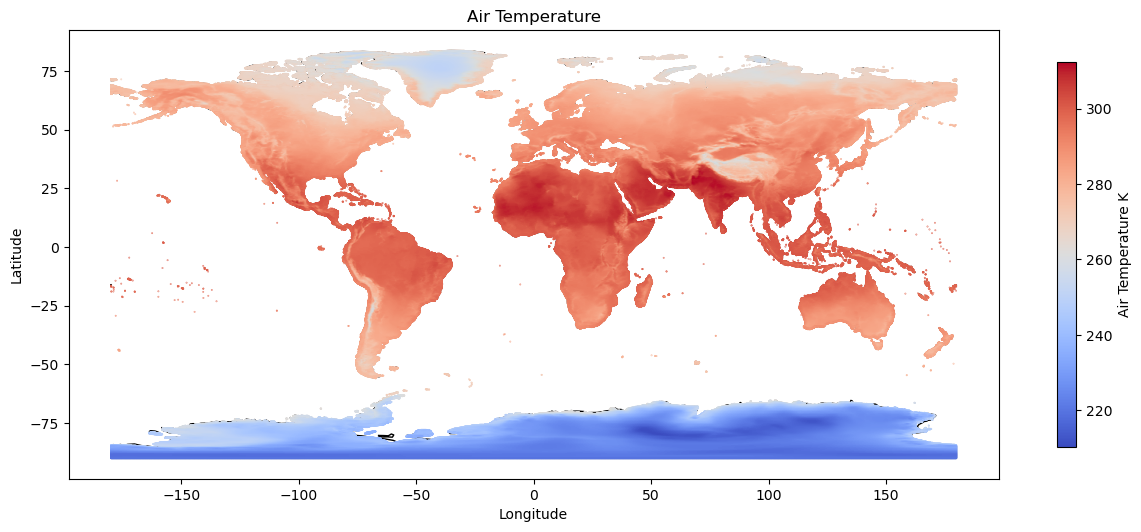

In [7]:
from ml4xcube.geo_plots import plot_geo_data

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

plot_geo_data(
    df             = dfdn,
    column_to_plot = 'air_temperature_2m',
    color_map      = 'coolwarm',
    title          = 'Air Temperature',
    label          = 'Air Temperature K'
)

Land Surface Temperature

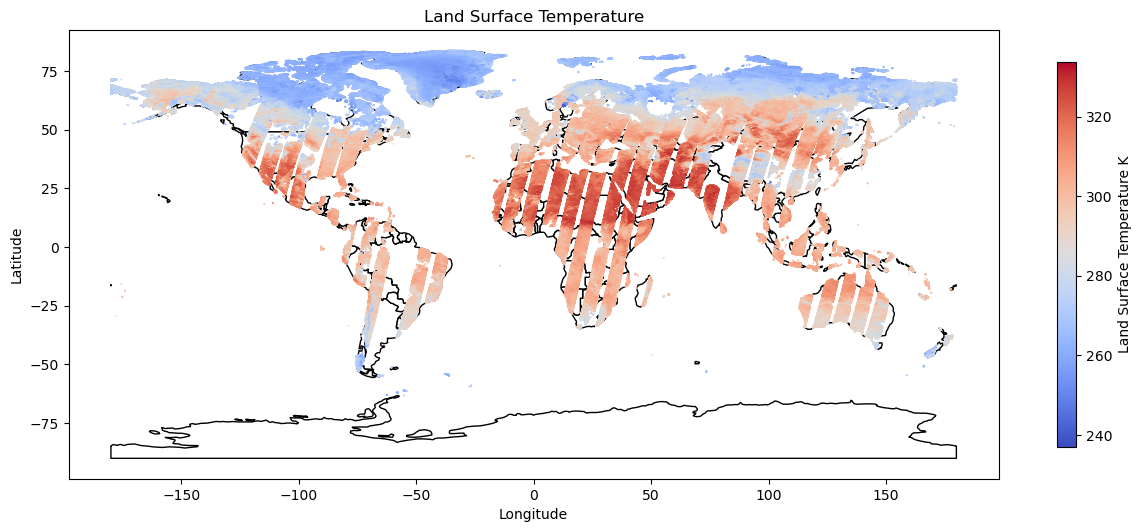

In [8]:
from ml4xcube.geo_plots import plot_geo_data

plot_geo_data(
    df             = dfdn,
    column_to_plot = 'land_surface_temperature',
    color_map      = 'coolwarm',
    title          = 'Land Surface Temperature',
    label          = 'Land Surface Temperature K'
)

### Assign train/test split
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [9]:
from ml4xcube.data_assignment import assign_rand_split, assign_block_split

# random sampling
#xds = assign_rand_split(
#    ds    = xdsm,
#    split = 0.8
#)

# block sampling
xds = assign_block_split(
    ds         = xdsm,
    block_size = [("time", 10), ("lat", 100), ("lon", 100)],
    split      = 0.8
)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

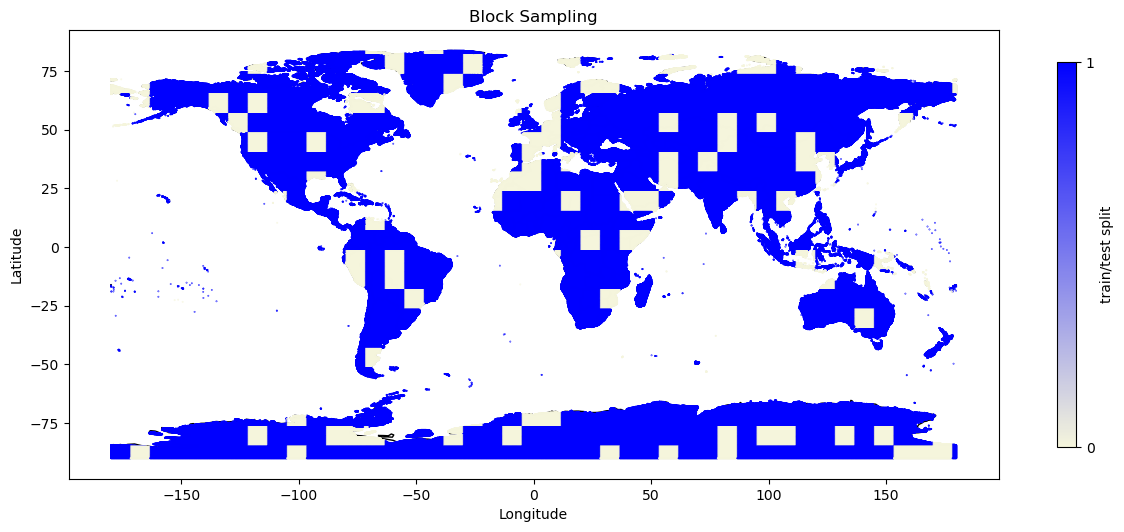

In [10]:
from ml4xcube.geo_plots import plot_geo_data
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

color_map = LinearSegmentedColormap.from_list("", ["beige","blue"])
plot_geo_data(
    df             = dfdn,
    column_to_plot = 'split',
    color_map      = color_map,
    title          = 'Block Sampling',
    label          = 'train/test split',
    ticks          = [0,1]
)

### Model set up

#### Initialize MLFlow experiment

In [11]:
experiment_name = "TensorFlow Regression of LST from AT with mlflow"
mlflow.set_experiment(experiment_name)

current_experiment = dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id      = current_experiment['experiment_id']

run_name = "TF_ESDC_LR_block_0.1"
mlflow.autolog()

2024/05/03 01:22:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2024/05/03 01:22:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/05/03 01:22:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/05/03 01:22:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/05/03 01:22:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


#### Train-/ and Test Set Creation and Preprocessing

In [12]:
from ml4xcube.datasets.xr_dataset import XrDataset

dataset = XrDataset(ds=xds, num_chunks=3, rand_chunk=False).get_dataset()

In [13]:
from ml4xcube.statistics import get_range, get_statistics

#at_range  = get_range(xds, 'air_temperature_2m')
#lst_range = get_range(xds, 'land_surface_temperature')

at_stat  = get_statistics(xds, 'air_temperature_2m')
lst_stat = get_statistics(xds, 'land_surface_temperature')

Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [14]:
from ml4xcube.statistics import standardize

X = standardize(dataset['air_temperature_2m'], *at_stat)
y = standardize(dataset['land_surface_temperature'], *lst_stat)

In [15]:
X_train, X_test = X[dataset['split'] == True], X[dataset['split'] == False]
y_train, y_test = y[dataset['split'] == True], y[dataset['split'] == False]

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [16]:
inputs      = L.Input(name="air_temperature_2m", shape=(1,))
output      = L.Dense(1, activation="linear", name="land_surface_temperature")(inputs)
model       = tf.keras.models.Model(inputs=inputs, outputs=output)

Enable logging for Tensorboard

In [17]:
log_dir = os.environ.get('TENSORBOARD_LOGDIR', 'logs') + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [18]:
lr     = 0.001
epochs = 20

### Train model

In [19]:
from ml4xcube.training.tensorflow import Trainer

with mlflow.start_run(experiment_id=experiment_id, run_name = run_name) as run:

    mlflow.log_param('lr', lr)
    mlflow.log_param('number_epochs', epochs)
    
    trainer = Trainer(
        model           = model, 
        train_data      = train_ds, 
        test_data       = test_ds, 
        optimizer       = "adam",
        learning_rate   = lr,
        early_stopping  = True,
        patience        = 5,
        best_model_path = 'best_model.keras',
        tf_log_dir      = log_dir, 
        mlflow_run      = mlflow,
        epochs          = epochs,
        batch_size      = 128,
        loss            = "mean_squared_error",
        metrics         = ["mae"]
    )
    
    model = trainer.train()

2024/05/03 01:22:49 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 
2024/05/03 01:22:49 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 


Epoch 1/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - loss: 0.1402 - mae: 0.2988 - val_loss: 0.0716 - val_mae: 0.2113
Epoch 2/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - loss: 0.0277 - mae: 0.1509 - val_loss: 0.0492 - val_mae: 0.1585
Epoch 3/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - loss: 0.0897 - mae: 0.2326 - val_loss: 0.0642 - val_mae: 0.1939
Epoch 4/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - loss: 0.0394 - mae: 0.1840 - val_loss: 0.0395 - val_mae: 0.1401
Epoch 5/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - loss: 0.0904 - mae: 0.2318 - val_loss: 0.0642 - val_mae: 0.1928
Epoch 6/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - loss: 0.0431 - mae: 0.1934 - val_loss: 0.0377 - val_mae: 0.1375
Epoch 7/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - loss: 0.0910 - mae: 0.2324 - val_loss: 0.0643 - val_mae: 0.1928
Epoch 8/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - loss: 0.0438 - mae: 0.1951 - val_loss: 0.0374 - val_mae: 0.1372
Epoch 9/20
1616/1616 ━━━━━━━

We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [20]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

land_surface_temperature  air_temperature_2m  \
lat        lon                                                         
 89.958333 -179.958333                       NaN          266.297180   
           -179.875000                       NaN          266.297180   
           -179.791667                       NaN          266.297180   
           -179.708333                       NaN          266.297180   
           -179.625000                       NaN          266.297180   
...                                          ...                 ...   
-89.958333  179.625000                       NaN          219.817398   
            179.708333                       NaN          219.817398   
            179.791667                       NaN          219.817398   
            179.875000                       NaN          219.817398   
            179.958333                       NaN          219.817398   

                             time  land_mask  split  
lat        lon                                       
 89.958333 -179.958333 2002-05-21      False    0.0  
           -179.875000 2002-05-21      False    0.0  
           -179.791667 2002-05-21      False    0.0  
           -179.708333 2002-05-21      False    0.0  
           -179.625000 2002-05-21      False    0.0  
...                           ...        ...    ...  
-89.958333  179.625000 2002-05-21       True    1.0  
            179.708333 2002-05-21       True    1.0  
            179.791667 2002-05-21       True    1.0  
            179.875000 2002-05-21       True    1.0  
            179.958333 2002-05-21       True    1.0  

[9331200 rows x 5 columns]

Predict missing Land Surface Temperature values from Air Temperature values

In [21]:
from ml4xcube.statistics import standardize, undo_standardizing

dfl = df[df['land_mask'] == True]
orig = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output = to_pred.drop('land_surface_temperature', axis = 1)

X = standardize(to_pred['air_temperature_2m'], *at_stat)
X = X.values

lstp = model.predict(X)
output['land_surface_temperature'] = undo_standardizing(lstp, *at_stat)
output

54346/54346 ━━━━━━━━━━━━━━━━━━━━ 16s 293us/step


air_temperature_2m       time  land_mask  split  \
lat        lon                                                            
 83.208333 -73.958333           266.152954 2002-05-21       True    1.0   
 83.125000 -77.041667           265.867096 2002-05-21       True    1.0   
           -76.958333           265.832367 2002-05-21       True    1.0   
           -76.875000           265.832367 2002-05-21       True    1.0   
           -76.791667           265.832367 2002-05-21       True    1.0   
...                                    ...        ...        ...    ...   
-89.958333  179.625000          219.817398 2002-05-21       True    1.0   
            179.708333          219.817398 2002-05-21       True    1.0   
            179.791667          219.817398 2002-05-21       True    1.0   
            179.875000          219.817398 2002-05-21       True    1.0   
            179.958333          219.817398 2002-05-21       True    1.0   

                        land_surface_temperature  
lat        lon                                    
 83.208333 -73.958333                 248.455719  
 83.125000 -77.041667                 247.945816  
           -76.958333                 247.883865  
           -76.875000                 247.883865  
           -76.791667                 247.883865  
...                                          ...  
-89.958333  179.625000                165.804855  
            179.708333                165.804855  
            179.791667                165.804855  
            179.875000                165.804855  
            179.958333                165.804855  

[1739067 rows x 5 columns]

### Plot Predictions

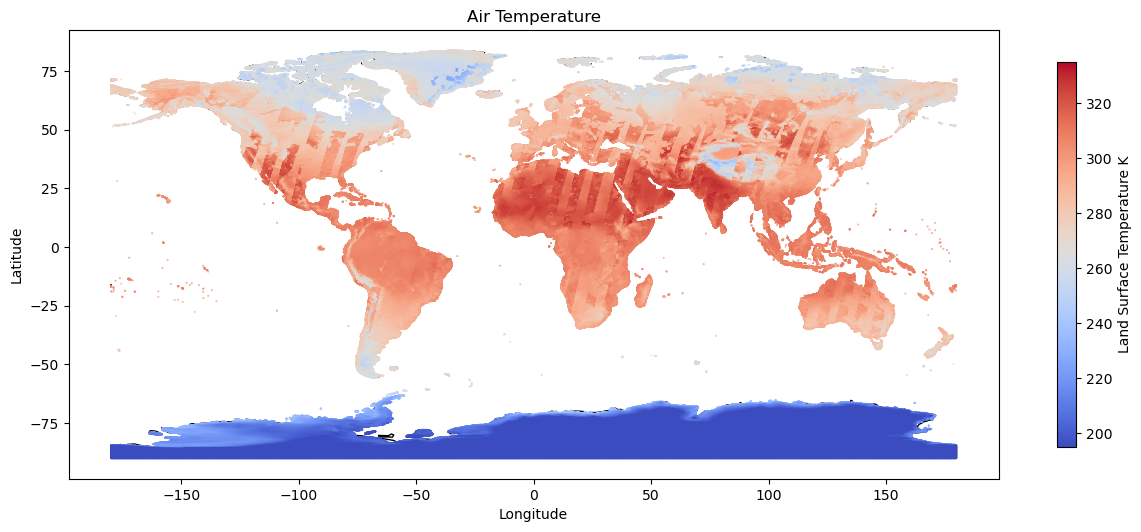

In [22]:
from ml4xcube.geo_plots import plot_geo_data

df = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

plot_geo_data(
    df             = lst,
    column_to_plot = 'land_surface_temperature',
    color_map      = 'coolwarm',
    title          = 'Air Temperature',
    label          = 'Land Surface Temperature K', 
    vmin           = 195,
    vmax           = 335
)